Import `quick` modules. For this demo, we will import the circuit instances and backend instances.

In [2]:
from quick.circuit import QiskitCircuit, PennylaneCircuit, CirqCircuit, TKETCircuit
from quick.backend import AerBackend, FakeIBMBackend

### Circuits Demo : Running quantum circuits

This notebook is dedicated to the demonstration of how `quick` can be used to run gate-based quantum circuits. Quantum circuits can be run on three paradigms:
1) Simulation Backends : Ideal simulators which can be used to get the statevector, operator, or counts of a circuit without any errors/noise.
2) Noisy Simulation Backends : Simulators which can emulate realistic noise to simulate the behavior of actual quantum hardware.
3) Quantum hardware : Actual quantum hardware which can be used to run quantum circuits and can only return the counts with some degree of noise.

In this notebook, we will go over some of these backends and how `quick` allows any supported framework to be run on any supported backend.

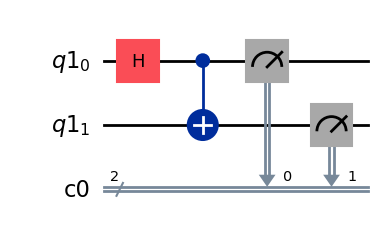

In [3]:
# Create a circuit
qiskit_circuit = QiskitCircuit(2)

# Apply a Hadamard gate to qubit 0
qiskit_circuit.H(0)
# Apply a CX gate to qubit 1 controlled by 0
qiskit_circuit.CX(0, 1)
# Apply a measurement to all qubits
qiskit_circuit.measure_all()
# Draw the circuit
qiskit_circuit.draw()

For development purposes, we mostly can use simulators as actual hardware is hard to access. However, for any application to be useful, we need to be able to have some degree of confidence that it will work adequately well on the desired hardware. This is where simulators are best utilized.

We can use `AerBackend` to perform ideal (or noisy) simulation using Qiskit Aer's Backend.

In [4]:
# Define the `quick.backend.AerBackend`
aer_backend = AerBackend()

# Get the counts of the circuit
counts = aer_backend.get_counts(circuit=qiskit_circuit, num_shots=1024)

# Get the statevector of the circuit
statevector = aer_backend.get_statevector(qiskit_circuit)

# Get the unitary of the circuit
unitary = aer_backend.get_operator(qiskit_circuit)

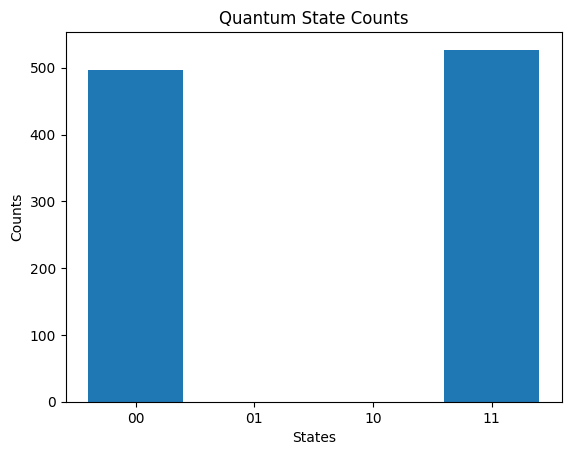

In [5]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Quantum State Counts')
plt.show()

To define noisy simulators we need to define the error expected for one qubit and two qubit gates. You can create custom simulators where you can add custom error for specific gates, specific topologies, etc. `AerBackend` will provide a simple way of doing noisy simulation.

In [6]:
# Define the `quick.backend.AerBackend`
noisy_aer_backend = AerBackend(0.5, 0.1)

# Get the counts of the circuit
counts = noisy_aer_backend.get_counts(circuit=qiskit_circuit, num_shots=1024)

# Get the statevector of the circuit
statevector = noisy_aer_backend.get_statevector(qiskit_circuit)

# Get the unitary of the circuit
unitary = noisy_aer_backend.get_operator(qiskit_circuit)

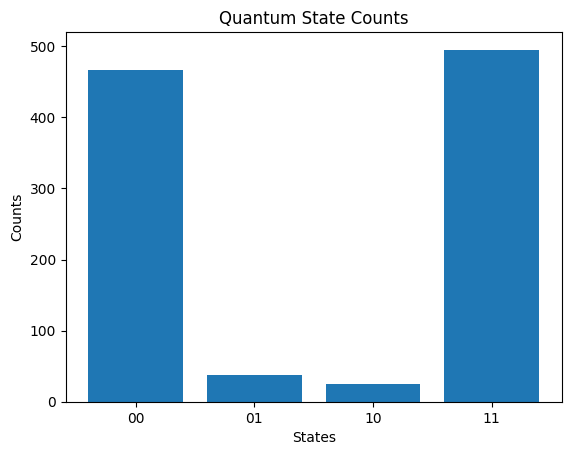

In [7]:
plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Quantum State Counts')
plt.show()

You can also access the backends through the `Circuit` instances.

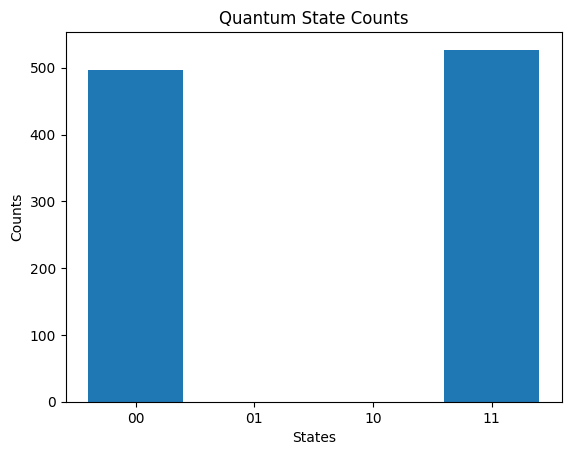

In [8]:
counts = qiskit_circuit.get_counts(1024, aer_backend)

plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Quantum State Counts')
plt.show()

With `quick`'s translation mechanism, you can also access the backends through the other `Circuit` instances. The way this works is that if the backend is not native to the framework passed, then it will first translate the circuit and then run the corresponding function.

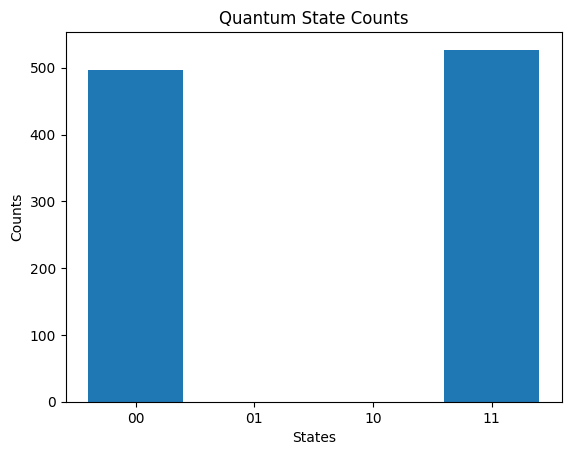

In [9]:
# Define a `TKETCircuit` instance with Bell state
tket_circuit = TKETCircuit(2)

tket_circuit.H(0)
tket_circuit.CX(0, 1)
tket_circuit.measure_all()

counts = tket_circuit.get_counts(1024, aer_backend)

plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Quantum State Counts')
plt.show()

### Hardware Emulators

`quick` provides access to both actual quantum hardware as well as fake emulators which simulate their behavior. With `quick.backend.FakeBackend` like `quick.backend.FakeIBMBackend` you can simulate a vast array of fake IBM backends.

The main difference between a noisy simulator and a fake backend is that fake backends are caliberated to simulate existing quantum hardware, and fall under noisy simulators. Furthermore, as they are emulating actual quantum hardware they impose quantum volume constraint on the circuits passed as well, i.e., number of qubits.

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService # type: ignore

# To use QiskitRuntime, we must pass in credientials
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="1e179eb7ed08178c1d0c10304bd10d8ebe9201b356c674fbb0c5ec2345c9935316662ac6d9a6c4d2d6e9af7a8b0d128e9c3502bb926b545b0b5069128d95fb9f")

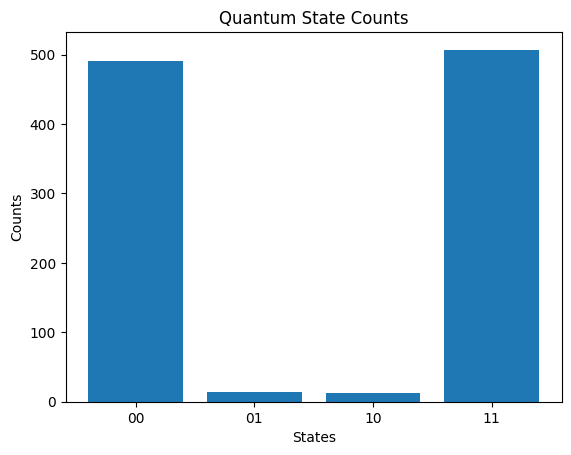

In [11]:
# Define a `FakeIBMBackend` instance
fake_ibm_backend = FakeIBMBackend("ibm_sherbrooke", qiskit_runtime=service)

# Get the counts of the circuit
counts = fake_ibm_backend.get_counts(circuit=qiskit_circuit, num_shots=1024)

plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Quantum State Counts')
plt.show()

<p>© 2024 Qualition Computing, all rights reserved.</p>